In this notebook, I'm going to try my hand at the Lyft Udacity challenge: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge. I'm going to build a U-Net, a variety of Fully Convolutional Neural Network first developed in this paper: https://arxiv.org/pdf/1411.4038.pdf. Ideally, my GPU ought to be able to handle this, since this paper was in 2015 and my GPU is top-line by those standards (but it might depend on how big the data is). Let's load and preprocess the data.

Note: this notebook is hacked-together from a few other kaggle solutions and tutorials!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import glob
import random
import cv2

Define some parameters.

In [2]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
N_CLASSES = 13
BATCH_SIZE = 32
EPOCHS = 100
src_dir = '/home/garrett/KagglesData/SelfDriving'

Read in all images, train test split, and store images and masks in a pandas dataframe for use with the FlowFromDataframe ImageDataGenerator method.

In [3]:
input_imgs_names = []
mask_names = []

for i in ['A', 'B', 'C', 'D', 'E']:
    input_imgs_names += glob.glob(os.path.join(src_dir, f'data{i}/data*/CameraRGB/*.png'))
    mask_names += glob.glob(os.path.join(src_dir, f'data{i}/data*/CameraSeg/*.png'))

num_samples = len(mask_names)
df = pd.DataFrame({'images':input_imgs_names , 'masks': mask_names})
df.reset_index(drop=True, inplace=True)
df.head(5)

XY_train,XY_test = train_test_split(df, train_size=0.8, random_state=0) 
XY_train.reset_index(drop=True, inplace=True)
XY_test.reset_index(drop=True, inplace=True)

XY_train.head(5)

,images,masks
0,/home/garrett/KagglesData/SelfDriving/dataC/da...,/home/garrett/KagglesData/SelfDriving/dataC/da...
1,/home/garrett/KagglesData/SelfDriving/dataD/da...,/home/garrett/KagglesData/SelfDriving/dataD/da...
2,/home/garrett/KagglesData/SelfDriving/dataA/da...,/home/garrett/KagglesData/SelfDriving/dataA/da...
3,/home/garrett/KagglesData/SelfDriving/dataA/da...,/home/garrett/KagglesData/SelfDriving/dataA/da...
4,/home/garrett/KagglesData/SelfDriving/dataB/da...,/home/garrett/KagglesData/SelfDriving/dataB/da...


Let's get a random test image and look at the image and its mask, to make sure they match. Only the last channel of the mask image contains the masks.

(-0.5, 799.5, 599.5, -0.5)

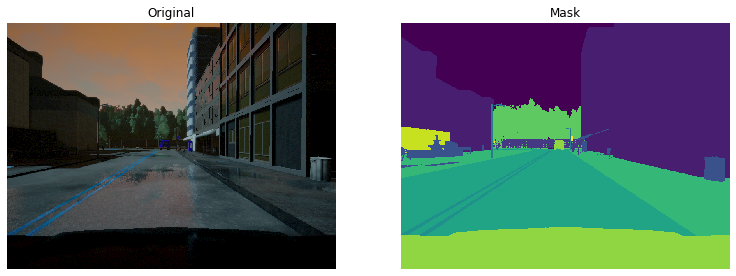

In [4]:
index = random.randint(0, len(XY_train)-1)
img = cv2.imread(XY_train.loc[index].at["images"])
mask = cv2.imread(XY_train.loc[index].at["masks"])[:, :, 2]

plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

In [32]:
image_datagen = ImageDataGenerator(rescale=1./255.)
mask_datagen = ImageDataGenerator()
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

def scale_img(image):
    image = cv2.resize(image, (WIDTH, HEIGHT))
    
def scale_mask(mask):
    mask = cv2.resize(mask, (WIDTH, HEIGHT))[:, :, 2]

image_generator = image_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="images",
    class_mode=None,
    batch_size = BATCH_SIZE,
    preprocessing_function = scale_img,
    seed=seed)
mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="masks",
    class_mode=None,
    batch_size = BATCH_SIZE,
    preprocessing_function = scale_mask,
    seed=seed)
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

Found 4000 validated image filenames.
Found 4000 validated image filenames.


In [33]:
for x, y in train_generator:
    break
print(x.shape,y.shape)

(32, 256, 256, 3) (32, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

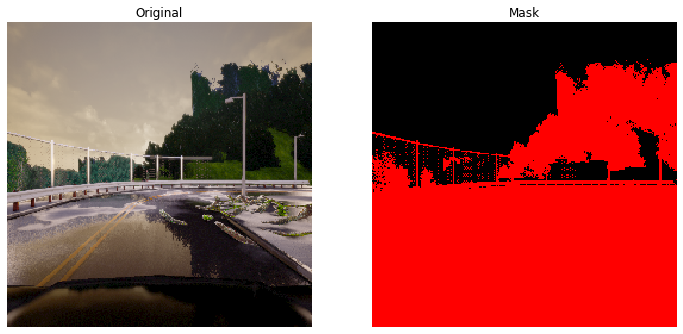

In [34]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0])
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(y[0])
plt.title('Mask')
plt.axis('off')